# Image Classification Project as Good and Bad, using QA dataset from the AI4IM project

## 1. Setting Up the Environment


In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA GeForce RTX 2060 SUPER, 8192 MiB, 7356 MiB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)


In [3]:
import tensorflow as tf
print("GPU is available" if tf.config.experimental.list_physical_devices("GPU") else "No GPU found")


GPU is available


## 2. Data Preparation and Structuring

#### Dataset

In [156]:
import os

dataset_d = './student_dataset_original/'
total_samples = sum(len(files) for _, _, files in os.walk(dataset_d))
print(f'Total samples in the dataset: {total_samples}')


Total samples in the dataset: 2882


In [157]:
import cv2

im_path = dataset_d + 'student_dataset/Good/S1/Image0000018545.bmp'
im = cv2.imread(im_path)
height, width, channels = im.shape
print(f'Image dimensions: {width}x{height} pixels, {channels} channels')


Image dimensions: 1051x147 pixels, 3 channels


#### Skip this cell, once dataset is split into train, validation and test directories

In [ ]:
# Skip this cell, once dataset structure is like this:
# student_dataset/
# ├── train/
# │   ├── Good/
# │   │   ├── S1/
# │   │   ├── S2/
# │   │   ├── S3/
# │   │   └── S4/
# │   └── Bad/
# │       ├── S1/
# │       ├── S2/
# │       ├── S3/
# │       └── S4/
# ├── validation/
# │   ├── Good/
# │   │   ├── S1/
# │   │   ├── S2/
# │   │   ├── S3/
# │   │   └── S4/
# │   └── Bad/
# │       ├── S1/
# │       ├── S2/
# │       ├── S3/
# │       └── S4/
# └── test/
#     ├── Good/
#     │   ├── S1/
#     │   ├── S2/
#     │   ├── S3/
#     │   └── S4/
#     └── Bad/
#         ├── S1/
#         ├── S2/
#         ├── S3/
#         └── S4/

In [3]:
import os
import shutil
from random import shuffle, seed

# # Define the root directory of dataset in Google Drive
# root_dir = '/content/drive/My Drive/student_dataset/'

# Define the root directory of dataset in local
root_dir = './student_dataset/'

# Define the subdirectories for "Good" and "Bad" images
good_dir = os.path.join(root_dir, 'Good')
bad_dir = os.path.join(root_dir, 'Bad')

# Define the target directories for "train," "validation," and "test"
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')  # New test directory


# Create the "train," "validation," and "test" directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# Percentage of data to use for validation
validation_split = 0.15
test_split = 0.1

# Process both "Good" and "Bad" images
for class_dir in [good_dir, bad_dir]:
    # Get a list of subdirectories (S1, S2, S3, S4)
    subdirs = [f.name for f in os.scandir(class_dir) if f.is_dir()]

    for subdir in subdirs:
        subdir_path = os.path.join(class_dir, subdir)

        # List all image files in the current subdirectory
        image_files = [f.name for f in os.scandir(subdir_path) if f.is_file()]

        # Set the random seed for shuffling
        seed(3)

        # Shuffle the list of image files
        shuffle(image_files)

        # Calculate the number of images for validation and test sets
        num_validation_samples = int(len(image_files) * validation_split)
        num_test_samples = int(len(image_files) * test_split)


        # Split the image files into training, validation, and test sets
        train_images = image_files[num_validation_samples + num_test_samples:]
        validation_images = image_files[:num_validation_samples]
        test_images = image_files[num_validation_samples:num_validation_samples + num_test_samples]


        # Create the corresponding "Good" or "Bad" directories in "train," "validation," and "test"
        train_class_dir = os.path.join(train_dir, os.path.basename(class_dir))
        validation_class_dir = os.path.join(validation_dir, os.path.basename(class_dir))
        test_class_dir = os.path.join(test_dir, os.path.basename(class_dir))


        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(validation_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)


        # Move images to the appropriate directories
        for image in train_images:
            src = os.path.join(subdir_path, image)
            dst = os.path.join(train_class_dir, subdir, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)

        for image in validation_images:
            src = os.path.join(subdir_path, image)
            dst = os.path.join(validation_class_dir, subdir, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)

        for image in test_images:
            src = os.path.join(subdir_path, image)
            dst = os.path.join(test_class_dir, subdir, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)

print("Data splitting into train, validation, and test directories is complete.")


Data splitting into train, validation, and test directories is complete.


We would have 1 directory for dataset:

* student_dataset/

Under student_dataset/:

2 folder for train and validation, test:

- ├── train/
- ├── validation/
- ├── test/

And under each of them, there will be 2 sub-directories:
- │   ├── Good/
- │   ├── Bad/

And under each sub-folder, there will be 4 sub-folders for 4 different camera images:
- │   │   ├── S1/
- │   │   ├── S2/
- │   │   ├── S3/
- │   │   ├── S4/


In [159]:
# Define the root directory of dataset in local
root_dir = './student_dataset/'

# Define the subdirectories for "Good" and "Bad" images
good_dir = os.path.join(root_dir, 'Good')
bad_dir = os.path.join(root_dir, 'Bad')

# Define the target directories for "train," "validation," and "test"
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')  # New test directory

num_train_samples = sum(len(files) for _, _, files in os.walk(train_dir))
num_validation_samples = sum(len(files) for _, _, files in os.walk(validation_dir))
num_test_samples = sum(len(files) for _, _, files in os.walk(test_dir))

print(f'Training set samples: {num_train_samples}')
print(f'Validation set samples: {num_validation_samples}')
print(f'Test set samples: {num_test_samples}')


Training set samples: 2168
Validation set samples: 429
Test set samples: 285


In [160]:
from collections import Counter

labels = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]
class_distribution = Counter()

for label in labels:
    class_path = os.path.join(train_dir, label)
    class_count = sum(len(files) for _, _, files in os.walk(class_path))
    class_distribution[label] = class_count

print('Class Distribution:')
for label, count in class_distribution.items():
    print(f'{label}: {count} samples')


Class Distribution:
Bad: 1071 samples
Good: 1097 samples


## 3. Data Preprocessing and Feature Engineering


### Data Preprocessing:



Here basic data preprocessing is being applied, including resizing images and normalizing pixel values. This ensures that all images have the same size and pixel values are within a specific range.

#### Data Augmentation


Data augmentation is a technique that generates new training examples by applying various transformations to existing images.
It is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.  
We make geometric and color space transformations (flipping, resizing, cropping, brightness, contrast) to increase the size and diversity of the training set.
It helps increase the diversity of the training dataset, reducing the risk of overfitting. In this step, we'll configure data augmentation for the training dataset.



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify image dimensions and batch size
image_width, image_height = 150, 150
batch_size = 32


# Data augmentation parameters for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to the range [0, 1]
    rotation_range=40,     # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the width of images by up to 20%
    height_shift_range=0.2,  # Randomly shift the height of images by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zoom in/out
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in new pixels created by transformations
)

# Data Augmentation for the validation dataset (only rescale, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Creating data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)


Found 2168 images belonging to 2 classes.
Found 429 images belonging to 2 classes.


We're using the ImageDataGenerator to perform data preprocessing. Images are resized to 150x150 pixels and pixel values are rescaled to the range [0, 1].



### Checking the binary classification indices for the model:


In [5]:
# Access the class indices
class_indices = train_generator.class_indices

# Print the class indices
print("Class Indices:", class_indices)

# Reverse the dictionary to get a mapping from indices to class names
inverse_class_indices = {v: k for k, v in class_indices.items()}
print("Inverse Class Indices:", inverse_class_indices)

Class Indices: {'Bad': 0, 'Good': 1}
Inverse Class Indices: {0: 'Bad', 1: 'Good'}


Class_mode is set to 'binary', so it assumes two classes.

Class Indices: {'Bad': 0, 'Good': 1}

If the model predicts class 0, it corresponds to 'bad', and if it predicts class 1, it corresponds to 'good'.

### Feature Engineering:



We are using a pre-trained model for feature extraction, using the VGG16 pre-trained model.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout


# Load the pre-trained VGG16 model (excluding the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with VGG16 base and additional layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


Loaded the VGG16 model with pre-trained weights, excluded the top layers, and added custom layers for classification. This allows us to leverage the pre-trained model's feature extraction capabilities.

### Number of Good Images vs. Number of Bad Images:

In [ ]:
import os

# Assuming your training set is structured like this
train_dir = '/content/drive/My Drive/student_dataset/train'
good_train_dir = os.path.join(train_dir, 'Good')
bad_train_dir = os.path.join(train_dir, 'Bad')

# Count the number of good and bad images in the training set
num_good_images = sum([len(files) for _, _, files in os.walk(good_train_dir)])
num_bad_images = sum([len(files) for _, _, files in os.walk(bad_train_dir)])

print("Number of Good Images in Training Set:", num_good_images)
print("Number of Bad Images in Training Set:", num_bad_images)


Number of Good Images in Training Set: 1097
Number of Bad Images in Training Set: 1071


## 4. Model Building


We are using Convolutional Neural Network (CNN), as it is powerful with image processing tasks.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Single-class classification model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


## 5. Model Compilation and Training


After defining the model, We will compile it and start training. We'll use binary cross-entropy loss for binary classification and the Adam optimizer.



In [ ]:
import json
import os

history_path = '/content/drive/My Drive/student_dataset/history.json'

# Check if the history file exists
if os.path.exists(history_path):
    # Load the history from the file
    with open(history_path, 'r') as f:
        history = json.load(f)
    print(f"Training history loaded from {history_path}")
else:
    # Train the model and save the history
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )
    with open(history_path, 'w') as f:
        json.dump(history.history, f)



Epoch 1/10
68/68 [==============================] - 1082s 16s/step - loss: 0.4851 - accuracy: 0.7528 - val_loss: 0.2154 - val_accuracy: 0.9091
Epoch 2/10
68/68 [==============================] - 19s 284ms/step - loss: 0.1371 - accuracy: 0.9516 - val_loss: 0.0500 - val_accuracy: 0.9860
Epoch 3/10
68/68 [==============================] - 20s 288ms/step - loss: 0.1104 - accuracy: 0.9677 - val_loss: 0.0390 - val_accuracy: 0.9930
Epoch 4/10
68/68 [==============================] - 19s 285ms/step - loss: 0.0736 - accuracy: 0.9783 - val_loss: 0.0484 - val_accuracy: 0.9814
Epoch 5/10
68/68 [==============================] - 20s 288ms/step - loss: 0.0790 - accuracy: 0.9751 - val_loss: 0.0699 - val_accuracy: 0.9790
Epoch 6/10
68/68 [==============================] - 21s 301ms/step - loss: 0.0731 - accuracy: 0.9792 - val_loss: 0.0451 - val_accuracy: 0.9883
Epoch 7/10
68/68 [==============================] - 19s 285ms/step - loss: 0.0665 - accuracy: 0.9811 - val_loss: 0.0548 - val_accuracy: 0.9883

time for training:21m

We train the model for 10 epochs as a starting point.



In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=len(validation_generator)
# )


## 6. Model Evaluation


 We will evaluate the model performance accuracy metrics.

In [ ]:
# Save the model
model.save('/path/to/saved_model.h5')

# Specify the path to your test dataset
# test_dir = '/content/drive/My Drive/student_dataset/test' 
test_dir = './student_dataset/test' 


test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy}')


Found 285 images belonging to 2 classes.
9/9 [==============================] - 104s 13s/step - loss: 0.0360 - accuracy: 0.9930
Test accuracy: 0.9929824471473694


time to complete evaluate: 2m

Found 285 images belonging to 2 classes.

9/9 [==============================] - 104s 13s/step - loss: 0.0360 - accuracy: 0.9930

Test accuracy: 0.9929824471473694



# Transfer Learning Using %10 of the Bad Images:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [28]:
# Define the root directory of dataset in local
root_dir = './student_dataset/'

Data Augmentation: Since the dataset is limited, we can use data augmentation techniques to artificially increase the size of the dataset. This can help in training the model effectively with less reliance on the original images.

Balanced Sampling: Instead of using all available bad images, we can randomly sample a smaller subset of bad images to create a more balanced dataset. This helps in preventing the model from being biased towards the class with more samples.

 ### Sampling a fraction of the bad images for training:

#### Skip this cell if already created train_limited_10 folder with limited bad images:

In [ ]:
import os
import shutil
from random import shuffle, seed

# # Define the root directory of the dataset in Google Drive
# dataset_dir = '/content/drive/My Drive/student_dataset/'
# Define the root directory of the dataset in local
dataset_dir = './student_dataset/'
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# Define the subdirectories for "Good" and "Bad" images in the training set
train_good_dir = os.path.join(dataset_dir, 'train', 'Good')
train_bad_dir = os.path.join(dataset_dir, 'train', 'Bad')

# Define the target directory for "training" with limited bad images
limited10_train_dir = os.path.join(dataset_dir, 'train_limited_10')
os.makedirs(limited10_train_dir, exist_ok=True)

# Percentage of bad images to use for training
fraction_of_bad_images = 0.1  # Only %10 of bad images will be used for the model

# Process "Bad" images in each subdirectory (S1, S2, S3, S4)
for subdir in os.listdir(train_bad_dir):
    subdir_path = os.path.join(train_bad_dir, subdir)

    # List all image files in the current subdirectory
    image_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    # Set the random seed for shuffling
    seed(3)

    # Shuffle the list of image files
    shuffle(image_files)

    # Calculate the number of bad images to use for training
    num_bad_images_to_use = int(len(image_files) * fraction_of_bad_images)

    # Copy a fraction of bad images to the limited training directory
    for image in image_files[:num_bad_images_to_use]:
        src = os.path.join(subdir_path, image)
        dst = os.path.join(limited10_train_dir, 'Bad', subdir, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("%10 Limited bad images copied to the training directory-train_limited_10.")


%10 Limited bad images copied to the training directory.


it selects a fraction of bad images from each subdirectory (S1, S2, S3, S4) in the 'Bad' training set and copies them to a new directory named 'train_limited_10'. The 'train_limited_10' directory will beused as the training set for the model.

#### Copy Good Images to 'train_limited_10'

In [ ]:
# Assuming you have the previous code loaded

# Define the target directory for "training" with limited bad images
limited10_train_dir = os.path.join(dataset_dir, 'train_limited_10')
os.makedirs(limited10_train_dir, exist_ok=True)

# Process "Good" images in each subdirectory (S1, S2, S3, S4)
for subdir in os.listdir(train_good_dir):
    subdir_path = os.path.join(train_good_dir, subdir)

    # List all image files in the current subdirectory
    image_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

    # Copy all good images to the limited training directory
    for image in image_files:
        src = os.path.join(subdir_path, image)
        dst = os.path.join(limited10_train_dir, 'Good', subdir, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("All good images copied to the training directory-train_limited_10.")


All good images copied to the training directory.


#### Number of Good Images vs. Number of Bad Images:

In [1]:
import os

# limited10_train_dir = '/content/drive/My Drive/student_dataset/train_limited_10'
limited10_train_dir = './student_dataset/train_limited_10'

good_train_dir = os.path.join(limited10_train_dir, 'Good')
bad_train_dir = os.path.join(limited10_train_dir, 'Bad')

# Count the number of good and bad images in the training set
num_good_images = sum([len(files) for _, _, files in os.walk(good_train_dir)])
num_bad_images = sum([len(files) for _, _, files in os.walk(bad_train_dir)])

print("Number of Good Images in Training Set:", num_good_images)
print("Number of Bad Images in Training Set:", num_bad_images)


Number of Good Images in Training Set: 1097
Number of Bad Images in Training Set: 105


As a result:
- Number of Good Images in Training Set: 1097
- Number of Bad Images in Training Set: 105

## 3. Data Preprocessing and Feature Engineering


### Preprocess and Augment the Limited Dataset

In [2]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the root directory of the dataset in Google Drive
# dataset_dir = '/content/drive/My Drive/student_dataset/'
# Define the root directory of the dataset in local
dataset_dir = './student_dataset/'
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# Specify image dimensions and batch size
image_width, image_height = 150, 150
batch_size = 32

# Data Augmentation for the validation dataset (only rescale, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 429 images belonging to 2 classes.


### Data augmentation for the limited set of bad images:

In [3]:
import os

# augmented10_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10/Bad'
augmented10_bad_dir = './student_dataset/train_augmented_bad_10/Bad'

# Check if the folder exists
if os.path.exists(augmented10_bad_dir) and os.path.isdir(augmented10_bad_dir):
    # Get the list of files (images) in the folder
    files = [file for file in os.listdir(augmented10_bad_dir) if os.path.isfile(os.path.join(augmented10_bad_dir, file))]

    # Print the number of images in the folder
    num_images = len([file for file in files if file.lower().endswith(('.bmp'))])
    print(f'The folder contains {num_images} images.')
else:
    print('The folder does not exist or is not a directory.')


The folder contains 992 images.


#### Skip this cell if already created augmented bad images for train:

In [18]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

# Specify image dimensions and batch size
image_width, image_height = 150, 150
batch_size = 32

# Set your limited dataset directory
# limited10_train_dir = '/content/drive/My Drive/student_dataset/train_limited_10'
limited10_train_dir = './student_dataset/train_limited_10'

# Create a directory to store augmented bad images
# augmented10_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10'
augmented10_bad_dir = './student_dataset/train_augmented_bad_10'
os.makedirs(augmented10_bad_dir, exist_ok=True)

# Create the Bad directory and populate it with augmented_bad images
bad_dir = os.path.join(augmented10_bad_dir, 'Bad')
os.makedirs(bad_dir, exist_ok=True)

# Create the Good directory with an empty file
good_dir = os.path.join(augmented10_bad_dir, 'Good')
os.makedirs(good_dir, exist_ok=True)

# Create an empty file inside the Good directory
empty_file_path = os.path.join(good_dir, 'empty.txt')
with open(empty_file_path, 'w') as empty_file:
    pass  # Creating an empty file

# Data augmentation for bad images
augmentation_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow the limited bad dataset from directory with data augmentation
augmented_bad_generator = augmentation_datagen.flow_from_directory(
    os.path.join(limited10_train_dir, 'Bad'),
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary',
    save_to_dir=os.path.join(augmented10_bad_dir, 'Bad'),  # Save augmented images to the Bad directory
    save_prefix='augmented_bad',   # Prefix for saved images
    save_format='bmp'              # Format for saved images
)

# Generate augmented images and save them to the directory
num_augmented_images = 992  # Total number of images to generate
num_generated_images = 0  # Counter for generated images

while num_generated_images < num_augmented_images:
    augmented_bad_generator.next()
    num_generated_images += batch_size
    if num_generated_images % (105 // batch_size * batch_size) == 0:  # After each epoch
        augmented_bad_generator.reset()

# If more images were generated than desired, delete the excess images
if num_generated_images > num_augmented_images:
    num_excess_images = num_generated_images - num_augmented_images
    for _ in range(num_excess_images):
        os.remove(os.path.join(bad_dir, f'augmented_bad_{num_generated_images - _}.bmp'))

print(f"{num_augmented_images} augmented bad images created and saved to {augmented10_bad_dir}.")

# # Generate augmented images and save them to the directory
# for _ in range(num_augmented_images):
#     augmented_bad_generator.next()
#     if (_+1) % (105 // batch_size) == 0:  # After each epoch
#         augmented_bad_generator.reset()




Found 105 images belonging to 4 classes.


992 augmented bad images created and saved to ./student_dataset/train_augmented_bad_10.


- Found 105 images belonging to 4 classes.
- 992 augmented bad images created and saved to ./student_dataset/train_augmented_bad_10.

eclipsed time: 5s

#### Number of Good Images vs. Number of Bad Images:

In [4]:
import os

# limited10_train_dir = '/content/drive/My Drive/student_dataset/train_limited_10'
# augmented10_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10/Bad'

limited10_train_dir = './student_dataset/train_limited_10'
augmented10_bad_dir = './student_dataset/train_augmented_bad_10/Bad'

good_train_dir = os.path.join(limited10_train_dir, 'Good')
bad_train_dir = os.path.join(limited10_train_dir, 'Bad')

# Count the number of good and bad images in the training set
num_good_images = sum([len(files) for _, _, files in os.walk(good_train_dir)])
num_bad_limited_images = sum([len(files) for _, _, files in os.walk(bad_train_dir)])
num_bad_augmented_images = sum([len(files) for _, _, files in os.walk(augmented10_bad_dir)])

print("Number of Good Images in Training Set:", num_good_images)
print("Number of Bad Images in Limited Training Set:", num_bad_limited_images)
print("Number of Bad Images in Augmented Training Set:", num_bad_augmented_images)

# Calculate the total number of bad images (limited + augmented)
total_bad_images = num_bad_limited_images + num_bad_augmented_images
print("Total Number of Bad Images in Training Set:", total_bad_images)


Number of Good Images in Training Set: 1097
Number of Bad Images in Limited Training Set: 105
Number of Bad Images in Augmented Training Set: 992
Total Number of Bad Images in Training Set: 1097


In [5]:
# student_dataset/
# ├── limited_train/
# │   ├── Good/
# │   │   ├── S1/
# │   │   └── ...
# │   └── Bad/
# │       ├── S1/
# │       └── ...
# └── augmented_bad/
#     ├── Bad/
#     │   ├── augmented_bad_image1.jpg
#     │   └── ...
#     └── Good/   # This directory is needed to maintain the class structure
#         └── empty.txt   # We should have an empty file to satisfy Keras' flow_from_directory requirements


In [ ]:
# import os

# # Define the root directory for augmented_bad
# augmented10_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10'

# # Create the Bad directory and populate it with augmented_bad images
# bad_dir = os.path.join(augmented10_bad_dir, 'Bad')
# os.makedirs(bad_dir, exist_ok=True)

# # Create the Good directory with an empty file
# good_dir = os.path.join(augmented10_bad_dir, 'Good')
# os.makedirs(good_dir, exist_ok=True)

# # Create an empty file inside the Good directory
# empty_file_path = os.path.join(good_dir, 'empty.txt')
# with open(empty_file_path, 'w') as empty_file:
#     pass  # Creating an empty file

# print(f"Folder structure for augmented_bad created at {augmented10_bad_dir}.")


Folder structure for augmented_bad created at /content/drive/My Drive/student_dataset/train_augmented_bad_10.


In [4]:
import os

# augmented10_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10'
augmented10_bad_dir = './student_dataset/train_augmented_bad_10'

good_train_dir = os.path.join(augmented10_bad_dir, 'Good')
bad_train_dir = os.path.join(augmented10_bad_dir, 'Bad')

# Count the number of good and bad images in the training set
num_good_images = sum([len(files) for _, _, files in os.walk(good_train_dir)])
num_bad_images = sum([len(files) for _, _, files in os.walk(bad_train_dir)])

print("Number of Good Images in Training Set:", num_good_images)
print("Number of Bad Images in Training Set:", num_bad_images)

Number of Good Images in Training Set: 1
Number of Bad Images in Training Set: 992


### Feature Engineering:


In [5]:

# limited_train_dir = '/content/drive/My Drive/student_dataset/train_limited_10'
# augmented_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10'

import numpy as np


limited_train_dir = './student_dataset/train_limited_10'
augmented_bad_dir = './student_dataset/train_augmented_bad_10'


# Data augmentation for both good and bad images in train set
limited_train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow the limited training set
limited_train_generator = limited_train_datagen.flow_from_directory(
    limited_train_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Flow the augmented bad images
augmented_bad_generator = limited_train_datagen.flow_from_directory(
    augmented_bad_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Combine the generators using the ConcatenateImageGenerator class
class ConcatenateImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, *generators):
        self.generators = generators
        self.length = sum(len(generator) for generator in generators)

    def __len__(self):
        return self.length

    # def __getitem__(self, index):
    #     return tuple(generator[index % len(generator)] for generator in self.generators)
    def __getitem__(self, index):
        # Get the inputs and labels from each generator
        batches = [generator[index % len(generator)] for generator in self.generators]
        
        # Concatenate the inputs and labels
        inputs = np.concatenate([batch[0] for batch in batches])
        labels = np.concatenate([batch[1] for batch in batches])
        
        return inputs, labels

# Create a combined generator
combined_generator = ConcatenateImageGenerator(limited_train_generator, augmented_bad_generator)


Found 1202 images belonging to 2 classes.


Found 992 images belonging to 2 classes.


We make a base_model with VGG16, and combined_model from base_model using Model(Functional API from Keras)

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

# Specify image dimensions and batch size
image_width, image_height = 150, 150
batch_size = 32

# Define multiple inputs for VGG16
# we need this multiple inputs because we will provide 'combined_generator' to the model
input_shape = (image_width, image_height, 3)
input_layer = Input(shape=input_shape)

# Load the pre-trained VGG16 model (excluding the top layers)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with VGG16 base and additional layers for classification
# Add additional layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)



# Create the combined model with the modified VGG16 base
combined_model = Model(inputs=input_layer, outputs=predictions)
# # Modify the VGG16 input layer to accept multiple inputs
# combined_model = Model(inputs=[base_model.input, input_layer], outputs=predictions)



In [8]:
combined_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 4. Model Building


In [7]:
combined_model.output_shape

(None, 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


# Single-class classification model on top of the combined model
final_model = Sequential()


# Add the combined model as the first layer
final_model.add(combined_model)
# !!this, adding combined_model as another layer to final model, produced error in the next line, where we try to add Conv2D layer with input_shape



# final_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# # For Sequential model:
# final_model.add(Conv2D(32, (3, 3), activation='relu'))
# final_model.add(MaxPooling2D(2, 2))
# final_model.add(Conv2D(64, (3, 3), activation='relu'))
# final_model.add(MaxPooling2D(2, 2))
# final_model.add(Conv2D(128, (3, 3), activation='relu'))
# final_model.add(MaxPooling2D(2, 2))

# final_model.add(Flatten())

final_model.add(Dense(256, activation='relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(1, activation='sigmoid'))
# This `final_model` includes the VGG16 base model (with its Conv2D layers) and additional Dense layers for classification. So we don't need to add additional Conv2D layers to this model.


In [9]:
# Display the model summary
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1)                 16812353  
                                                                 
 dense_2 (Dense)             (None, 256)               512       
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,813,122
Trainable params: 2,098,434
Non-trainable params: 14,714,688
_________________________________________________________________


## 5. Model Compilation and Training

### train the final_model:

In [11]:
from tensorflow.keras.models import load_model

import json
import os

# history_path = '/content/drive/My Drive/student_dataset/history_final_model_limited10.json'
history_path = './student_dataset/history_final_model_limited10.json'
model_path = './student_dataset/model_saves/saved_final_model_limited10.h5'


# Check if the history and model file exists
if os.path.exists(model_path) and os.path.exists(history_path):
    # Load the model from the file
    final_model = load_model(model_path)
    print(f"Model loaded from {model_path}")


    # Load the history from the file
    with open(history_path, 'r') as f:
        history10 = json.load(f)
    print(f"Training history10 loaded from {history_path}")
else:
    # Train the final_model and save the history
    final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the final_model using the combined generator
    history10 = final_model.fit(
        combined_generator,
        steps_per_epoch=len(combined_generator),
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )
    
    # Save the training history
    with open(history_path, 'w') as f:
        json.dump(history10.history, f)
    print(f"Training history10 saved at {history_path}")
        
    # Save the model
    final_model.save(model_path)
    print(f"Final model saved at {model_path}")



Model loaded from ./student_dataset/saved_final_model_limited10.h5
Training history10 loaded from ./student_dataset/history_final_model_limited10.json


trainin time: 3m 9.9s

Epoch 1/10
69/69 [==============================] - 20s 273ms/step - loss: 0.5663 - accuracy: 0.9748 - val_loss: 0.5213 - val_accuracy: 0.8531

Epoch 2/10
69/69 [==============================] - 19s 270ms/step - loss: 0.3499 - accuracy: 0.9871 - val_loss: 0.3071 - val_accuracy: 0.9371

Epoch 3/10
69/69 [==============================] - 19s 272ms/step - loss: 0.1817 - accuracy: 0.9882 - val_loss: 0.3187 - val_accuracy: 0.9091

Epoch 4/10
69/69 [==============================] - 19s 273ms/step - loss: 0.0990 - accuracy: 0.9891 - val_loss: 0.1911 - val_accuracy: 0.9464

Epoch 5/10
69/69 [==============================] - 19s 274ms/step - loss: 0.0727 - accuracy: 0.9871 - val_loss: 0.1246 - val_accuracy: 0.9697

Epoch 6/10
69/69 [==============================] - 19s 273ms/step - loss: 0.0628 - accuracy: 0.9873 - val_loss: 0.2864 - val_accuracy: 0.9254

Epoch 7/10
69/69 [==============================] - 19s 274ms/step - loss: 0.0586 - accuracy: 0.9868 - val_loss: 0.3118 - val_accuracy: 0.9184

Epoch 8/10
69/69 [==============================] - 19s 273ms/step - loss: 0.0404 - accuracy: 0.9902 - val_loss: 0.1634 - val_accuracy: 0.9510

Epoch 9/10
69/69 [==============================] - 19s 272ms/step - loss: 0.0427 - accuracy: 0.9916 - val_loss: 0.2024 - val_accuracy: 0.9487

Epoch 10/10
69/69 [==============================] - 19s 271ms/step - loss: 0.0389 - accuracy: 0.9905 - val_loss: 0.1044 - val_accuracy: 0.9720


### train the combined_model(if needed, as alternative ):

In [12]:

import json
import os

# history_path = '/content/drive/My Drive/student_dataset/history_final_model_limited10.json'
history_path = './student_dataset/history_final_model_limited10.json'


# Check if the history file exists
if os.path.exists(history_path):
    # Load the history from the file
    with open(history_path, 'r') as f:
        history10 = json.load(f)
    print(f"Training history10 loaded from {history_path}")
else:
    # Train the combined_model and save the history
    combined_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the final_model using the combined generator
    history10 = combined_model.fit(
        combined_generator,
        steps_per_epoch=len(combined_generator),
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )
    # Save the training history
    with open(history_path, 'w') as f:
        json.dump(history10.history, f)



Epoch 1/10
69/69 [==============================] - 51s 610ms/step - loss: 0.2398 - accuracy: 0.9228 - val_loss: 0.4602 - val_accuracy: 0.8368
Epoch 2/10
69/69 [==============================] - 19s 274ms/step - loss: 0.0547 - accuracy: 0.9843 - val_loss: 0.2217 - val_accuracy: 0.9138
Epoch 3/10
69/69 [==============================] - 19s 273ms/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.2970 - val_accuracy: 0.9091
Epoch 4/10
69/69 [==============================] - 19s 273ms/step - loss: 0.0380 - accuracy: 0.9873 - val_loss: 0.3860 - val_accuracy: 0.8788
Epoch 5/10
69/69 [==============================] - 19s 272ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.1150 - val_accuracy: 0.9534
Epoch 6/10
69/69 [==============================] - 19s 272ms/step - loss: 0.0282 - accuracy: 0.9898 - val_loss: 0.1232 - val_accuracy: 0.9464
Epoch 7/10
69/69 [==============================] - 19s 272ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 0.0770 - val_accuracy: 0.9744

time for training: 3m 41.3s

Epoch 1/10

69/69 [==============================] - 51s 610ms/step - loss: 0.2398 - accuracy: 0.9228 - val_loss: 0.4602 - val_accuracy: 0.8368

Epoch 2/10

69/69 [==============================] - 19s 274ms/step - loss: 0.0547 - accuracy: 0.9843 - val_loss: 0.2217 - val_accuracy: 0.9138

Epoch 3/10

69/69 [==============================] - 19s 273ms/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.2970 - val_accuracy: 0.9091

Epoch 4/10

69/69 [==============================] - 19s 273ms/step - loss: 0.0380 - accuracy: 0.9873 - val_loss: 0.3860 - val_accuracy: 0.8788

Epoch 5/10

69/69 [==============================] - 19s 272ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.1150 - val_accuracy: 0.9534

Epoch 6/10

69/69 [==============================] - 19s 272ms/step - loss: 0.0282 - accuracy: 0.9898 - val_loss: 0.1232 - val_accuracy: 0.9464

Epoch 7/10

69/69 [==============================] - 19s 272ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 0.0770 - val_accuracy: 0.9744

Epoch 8/10

69/69 [==============================] - 19s 272ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.1437 - val_accuracy: 0.9441

Epoch 9/10

69/69 [==============================] - 19s 271ms/step - loss: 0.0264 - accuracy: 0.9932 - val_loss: 0.1019 - val_accuracy: 0.9580

Epoch 10/10

69/69 [==============================] - 19s 272ms/step - loss: 0.0311 - accuracy: 0.9905 - val_loss: 0.1047 - val_accuracy: 0.9557


## 5B. Detecting and Avoiding Overfitting

In the Model Building, dropout layers are added after each pooling layer and before the dense layers. The Dropout(0.2) means that 20% of the neurons will be randomly dropped out during training, helping to prevent overfitting.

The EarlyStopping callback monitors the validation loss and stops training if there is no improvement for a certain number of epochs (specified by patience). The restore_best_weights=True option restores the weights of the model to the ones that had the best performance on the validation set.

In [66]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


import json
import os

# history_path = '/content/drive/My Drive/student_dataset/history_final_model_limited10.json'
history_path = './student_dataset/history_final_model_limited10_earlystop.json'
model_path = './student_dataset/model_saves/saved_final_model_limited10_earlystop.h5'


# Check if the history and model file exists
if os.path.exists(model_path) and os.path.exists(history_path):
    # Load the model from the file
    final_model = load_model(model_path)
    print(f"Model loaded from {model_path}")


    # Load the history from the file
    with open(history_path, 'r') as f:
        history10 = json.load(f)
    print(f"Training history10 loaded from {history_path}")
else:
    # Train the final_model and save the history
    final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


    # Train the final_model using the combined generator
    history10 = final_model.fit(
        combined_generator,
        steps_per_epoch=len(combined_generator),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping]
    )
    
    # Save the training history
    with open(history_path, 'w') as f:
        json.dump(history10.history, f)
    print(f"Training history10 saved at {history_path}")
        
    # Save the model
    final_model.save(model_path)
    print(f"Final model saved at {model_path}")



Epoch 1/20
69/69 [==============================] - 29s 400ms/step - loss: 0.0471 - accuracy: 0.9900 - val_loss: 0.3298 - val_accuracy: 0.9207
Epoch 2/20
69/69 [==============================] - 19s 271ms/step - loss: 0.0397 - accuracy: 0.9905 - val_loss: 0.1106 - val_accuracy: 0.9744
Epoch 3/20
69/69 [==============================] - 19s 272ms/step - loss: 0.0415 - accuracy: 0.9907 - val_loss: 0.2675 - val_accuracy: 0.9347
Epoch 4/20
69/69 [==============================] - 19s 270ms/step - loss: 0.0285 - accuracy: 0.9939 - val_loss: 0.2921 - val_accuracy: 0.9324
Epoch 5/20
69/69 [==============================] - 19s 269ms/step - loss: 0.0421 - accuracy: 0.9902 - val_loss: 0.1161 - val_accuracy: 0.9674
Training history10 saved at ./student_dataset/history_final_model_limited10_earlystop.json
Final model saved at ./student_dataset/model_saves/saved_final_model_limited10_earlystop.h5


training time: 1m 44.3s

Epoch 1/20
69/69 [==============================] - 29s 400ms/step - loss: 0.0471 - accuracy: 0.9900 - val_loss: 0.3298 - val_accuracy: 0.9207

Epoch 2/20
69/69 [==============================] - 19s 271ms/step - loss: 0.0397 - accuracy: 0.9905 - val_loss: 0.1106 - val_accuracy: 0.9744

Epoch 3/20
69/69 [==============================] - 19s 272ms/step - loss: 0.0415 - accuracy: 0.9907 - val_loss: 0.2675 - val_accuracy: 0.9347

Epoch 4/20
69/69 [==============================] - 19s 270ms/step - loss: 0.0285 - accuracy: 0.9939 - val_loss: 0.2921 - val_accuracy: 0.9324

Epoch 5/20
69/69 [==============================] - 19s 269ms/step - loss: 0.0421 - accuracy: 0.9902 - val_loss: 0.1161 - val_accuracy: 0.9674

Training history10 saved at ./student_dataset/history_final_model_limited10_earlystop.json

Final model saved at ./student_dataset/model_saves/saved_final_model_limited10_earlystop.h5


## 6. Model Evaluation

In [67]:
# Evaluate on the validation set

validation_loss, validation_accuracy = final_model.evaluate(validation_generator, steps=len(validation_generator))
print(f'Validation accuracy: {validation_accuracy}')

14/14 [==============================] - 1s 41ms/step - loss: 0.1106 - accuracy: 0.9744
Validation accuracy: 0.9743589758872986


14/14 [==============================] - 1s 40ms/step - loss: 0.1044 - accuracy: 0.9720

Validation accuracy: 0.9720279574394226

time: 6.1s


early stopping:

14/14 [==============================] - 1s 41ms/step - loss: 0.1106 - accuracy: 0.9744

Validation accuracy: 0.9743589758872986

time:0.8s

In [68]:

# Save the model
# final_model.save('/content/drive/My Drive/student_dataset/saved_final_model_limited10.h5')

# # Check if the model file exists
# if os.path.exists(model_path) and os.path.exists(history_path):
#     # Load the model from the file
#     final_model = load_model(model_path)
#     print(f"Model loaded from {model_path}")
# else:
#     final_model.save(model_path)
#     print(f"Model saved at {model_path}")
    

# Specify the path to your test dataset
# test_dir = '/content/drive/My Drive/student_dataset/test'
test_dir = './student_dataset/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = final_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy of the final model: {test_accuracy}')


Found 285 images belonging to 2 classes.


9/9 [==============================] - 1s 45ms/step - loss: 0.1510 - accuracy: 0.9614
Test accuracy of the final model: 0.961403489112854


Found 285 images belonging to 2 classes.

9/9 [==============================] - 5s 615ms/step - loss: 0.1421 - accuracy: 0.9579

Test accuracy of the final model: 0.9578947424888611

time:3s


Found 285 images belonging to 2 classes.

9/9 [==============================] - 1s 45ms/step - loss: 0.1510 - accuracy: 0.9614

Test accuracy of the final model: 0.961403489112854

time:0.8s

## 7. Visualize the training history to analyze the model's performance over epochs.


In [20]:
predictions = final_model.predict(test_generator)
print("Predictions:", predictions)

9/9 [==============================] - 1s 42ms/step
Predictions: [[0.99040365]
 [0.99412125]
 [0.9940895 ]
 [0.99411666]
 [0.00733081]
 [0.9941134 ]
 [0.00738747]
 [0.9939727 ]
 [0.9932801 ]
 [0.99394304]
 [0.9941204 ]
 [0.00741441]
 [0.00840433]
 [0.9941127 ]
 [0.99393505]
 [0.0073685 ]
 [0.00743103]
 [0.01227738]
 [0.00766874]
 [0.9941223 ]
 [0.9941241 ]
 [0.00735275]
 [0.0073259 ]
 [0.9940876 ]
 [0.00781078]
 [0.00766705]
 [0.9941234 ]
 [0.00733562]
 [0.9941168 ]
 [0.9591802 ]
 [0.9843142 ]
 [0.00734084]
 [0.9940807 ]
 [0.99390185]
 [0.9939148 ]
 [0.02254771]
 [0.99411964]
 [0.9940904 ]
 [0.9939814 ]
 [0.00732592]
 [0.9940977 ]
 [0.99387336]
 [0.00807043]
 [0.9941223 ]
 [0.4363346 ]
 [0.00732813]
 [0.9941223 ]
 [0.994124  ]
 [0.00772344]
 [0.00732552]
 [0.82612395]
 [0.994052  ]
 [0.9941087 ]
 [0.9941158 ]
 [0.9940455 ]
 [0.00826477]
 [0.99412435]
 [0.99411917]
 [0.00732565]
 [0.99412376]
 [0.01249261]
 [0.99202174]
 [0.00749167]
 [0.9940148 ]
 [0.9933414 ]
 [0.00732811]
 [0.0101087

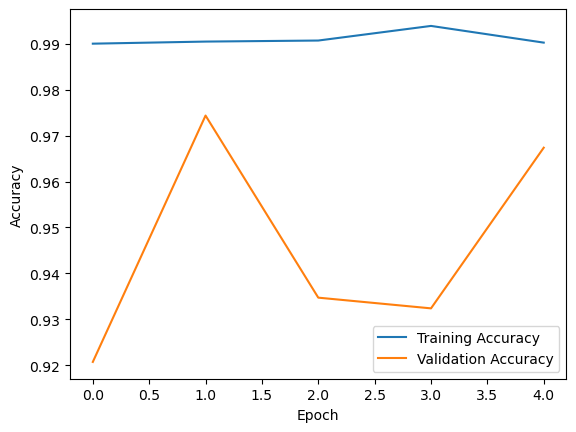

1/1 [==============================] - 0s 134ms/step
Sample 1: Predicted class - Good, Actual class - Good
1/1 [==============================] - 0s 19ms/step
Sample 2: Predicted class - Good, Actual class - Good
1/1 [==============================] - 0s 19ms/step
Sample 3: Predicted class - Good, Actual class - Good
1/1 [==============================] - 0s 20ms/step
Sample 4: Predicted class - Good, Actual class - Good
1/1 [==============================] - 0s 20ms/step
Sample 5: Predicted class - Bad, Actual class - Bad
1/1 [==============================] - 0s 20ms/step
Sample 6: Predicted class - Good, Actual class - Good
1/1 [==============================] - 0s 20ms/step
Sample 7: Predicted class - Bad, Actual class - Bad
1/1 [==============================] - 0s 20ms/step
Sample 8: Predicted class - Good, Actual class - Good
1/1 [==============================] - 0s 126ms/step
Sample 9: Predicted class - Bad, Actual class - Bad
1/1 [==============================] - 0s 21ms/ste

In [70]:
import matplotlib.pyplot as plt

# Plot training history
# # directly trained:
plt.plot(history10.history['accuracy'], label='Training Accuracy')
plt.plot(history10.history['val_accuracy'], label='Validation Accuracy')
# If loaded from a file:
# plt.plot(history10['accuracy'], label='Training Accuracy')
# plt.plot(history10['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# We can also visualize some predictions on new data
num_samples = 10
for i in range(num_samples):
    sample, label = test_generator.next()
    prediction = final_model.predict(sample)
    predicted_class = 'Good' if prediction[0] < 0.5 else 'Bad'
    actual_class = 'Good' if label[0] < 0.5 else 'Bad'
    print(f"Sample {i + 1}: Predicted class - {predicted_class}, Actual class - {actual_class}")



## 8. Model Interpretability

We can use Grad-CAM to visualize which parts of the image the model is focusing on.


- To understand how your model is making predictions for images it has seen during training, we choose an image from the training set.
- To understand how your model generalizes to unseen data, we choose an image from the validation or test set.

The goal of model interpretability in this context is to understand which parts of the image are influencing the model's predictions. So, it can be insightful to choose images that the model predicted correctly as well as images that the model predicted incorrectly.

In [17]:
# Access the class indices
class_indices = test_generator.class_indices

# Print the class indices
print("Class Indices:", class_indices)

# Reverse the dictionary to get a mapping from indices to class names
inverse_class_indices = {v: k for k, v in class_indices.items()}
print("Inverse Class Indices:", inverse_class_indices)

Class Indices: {'Bad': 0, 'Good': 1}
Inverse Class Indices: {0: 'Bad', 1: 'Good'}


In [18]:
# Get the filenames from the generator
filenames = test_generator.filenames

# Get the true labels from the generator
true_labels = test_generator.classes

# Predict labels for the test set
predictions = final_model.predict(test_generator, steps=len(test_generator))

# For binary classification, we threshold the predictions at 0.5
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Find the indices of correctly and incorrectly classified images
correct_indices = np.where(predicted_labels == true_labels)[0]
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Print some correctly and incorrectly classified image paths
print("Correctly classified images:")
for i in correct_indices[:5]:
    print(f"Index: {correct_indices[i]}, Filename: {filenames[i]}, Predicted Class: {predicted_labels[i]}")

print("\nIncorrectly classified images:")
for i in incorrect_indices[:5]:
    print(f"Index: {incorrect_indices[i]}, Filename: {filenames[i]}, Predicted Class: {predicted_labels[i]}")

9/9 [==============================] - 1s 67ms/step
Correctly classified images:
Index: 7, Filename: Bad\S1\Image0000011078.bmp, Predicted Class: 0
Index: 12, Filename: Bad\S1\Image0000011081.bmp, Predicted Class: 0
Index: 14, Filename: Bad\S1\Image0000011108.bmp, Predicted Class: 0
Index: 17, Filename: Bad\S1\Image0000011112.bmp, Predicted Class: 0
Index: 23, Filename: Bad\S1\Image0000011117.bmp, Predicted Class: 0

Incorrectly classified images:
Index: 0, Filename: Bad\S1\Image0000011071.bmp, Predicted Class: 1
Index: 1, Filename: Bad\S1\Image0000011076.bmp, Predicted Class: 1
Index: 2, Filename: Bad\S1\Image0000011077.bmp, Predicted Class: 1
Index: 9, Filename: Bad\S1\Image0000011080.bmp, Predicted Class: 1
Index: 16, Filename: Bad\S1\Image0000011122.bmp, Predicted Class: 1


9/9 [==============================] - 1s 64ms/step

Correctly classified images:

Index: 0, Filename: Bad\S1\Image0000011071.bmp, Predicted Class: 0

Index: 1, Filename: Bad\S1\Image0000011076.bmp, Predicted Class: 0

Index: 2, Filename: Bad\S1\Image0000011077.bmp, Predicted Class: 0

Index: 3, Filename: Bad\S1\Image0000011078.bmp, Predicted Class: 0

Index: 7, Filename: Bad\S1\Image0000011081.bmp, Predicted Class: 0


Incorrectly classified images:

Index: 12, Filename: Bad\S1\Image0000011080.bmp, Predicted Class: 1

Index: 14, Filename: Bad\S1\Image0000011108.bmp, Predicted Class: 1

Index: 19, Filename: Bad\S1\Image0000011117.bmp, Predicted Class: 1

Index: 21, Filename: Bad\S1\Image0000018743.bmp, Predicted Class: 1

Index: 25, Filename: Bad\S1\Image0000018773.bmp, Predicted Class: 1


In [33]:
# Print the model summary
combined_model.summary()
# final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [43]:
# Get the last convolutional layer
last_conv_layer = None
for layer in reversed(combined_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer
        break

# Print the name of the last convolutional layer
if last_conv_layer is not None:
    print("The name of the last convolutional layer is:", last_conv_layer.name)
else:
    print("No Conv2D layers found.")

The name of the last convolutional layer is: block5_conv3


pip install opencv-python from anaconda prompt to the env

%pip install tf-keras-vis tensorflow

In [26]:
import cv2
print (cv2.__version__)

4.8.1


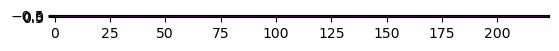

In [45]:
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam


# Load and resize the image
img_path = root_dir + 'test\Bad\S1\Image0000011078.bmp'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Now you can use x as input to your model
cam = gradcam(loss, x)

# Create a Gradcam object
gradcam = Gradcam(model)

# Define a loss function for Grad-CAM
def loss(output):
    return (output[0][class_idx],)

# Generate saliency map with Grad-CAM
cam = gradcam(loss, x)
cam = normalize(cam)

# Display Grad-CAM
import matplotlib.pyplot as plt
plt.imshow(cam[:, :, 0])
plt.show()

## 9. Hyperparameter Tuning

%pip install keras-tuner

In [48]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    input_shape = (150, 150, 3)
    input_layer = Input(shape=input_shape)
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for i in range(hp.Int('num_layers', 1, 5)):
        x = Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu')(x)
        x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=predictions)
    final_model = Sequential()
    final_model.add(combined_model)
    final_model.add(Dense(256, activation='relu'))
    final_model.add(Dropout(0.5))
    final_model.add(Dense(1, activation='sigmoid'))



    final_model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return final_model

In [49]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='hyperparam_dir',
    project_name='ImageClassification')

tuner.search_space_summary()

tuner.search(combined_generator,
             steps_per_epoch=len(combined_generator),
             epochs=10,
             validation_data=validation_generator,
             validation_steps=len(validation_generator))

tuner.results_summary()

Trial 5 Complete [00h 09m 33s]
val_accuracy: 0.8896659016609192

Best val_accuracy So Far: 0.9852369825045267
Total elapsed time: 00h 47m 41s
Results summary
Results in hyperparam_dir\ImageClassification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
num_layers: 4
units_0: 192
learning_rate: 0.001
units_1: 32
units_2: 32
units_3: 32
Score: 0.9852369825045267

Trial 2 summary
Hyperparameters:
num_layers: 2
units_0: 128
learning_rate: 0.0001
units_1: 160
units_2: 320
units_3: 224
Score: 0.9836829900741577

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 512
learning_rate: 0.001
Score: 0.9766899744669596

Trial 3 summary
Hyperparameters:
num_layers: 1
units_0: 320
learning_rate: 0.01
units_1: 224
units_2: 128
units_3: 448
Score: 0.9689199924468994

Trial 4 summary
Hyperparameters:
num_layers: 2
units_0: 384
learning_rate: 0.001
units_1: 480
units_2: 96
units_3: 480
Score: 0.8896659016609192


Trial 5 Complete [00h 09m 33s]

val_accuracy: 0.8896659016609192

Best val_accuracy So Far: 0.9852369825045267

Total elapsed time: 00h 47m 41s

Results summary

Results in hyperparam_dir\ImageClassification

Showing 10 best trials

Objective(name="val_accuracy", direction="max")

### Retrieve the best model

In [50]:
best_model = tuner.get_best_models(num_models=1)[0]

In [52]:
print(best_model)

### Evaluate the best model

In [53]:
test_dir = './student_dataset/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

tuned_test_loss, tuned_test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy of the final model: {tuned_test_accuracy}')

Found 285 images belonging to 2 classes.
9/9 [==============================] - 1s 44ms/step - loss: 0.1702 - accuracy: 0.9860
Test accuracy of the final model: 0.9859648942947388


Before tuning:
- Test accuracy of the final model: 0.9578947424888611

After hyperparameter tuning:
- Test accuracy of the final model: 0.9859648942947388

### Inspect the best hyperparameters

In [55]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'num_layers': 4, 'units_0': 192, 'learning_rate': 0.001, 'units_1': 32, 'units_2': 32, 'units_3': 32}


### Re-train the model with the best hyperparameters

In [56]:
best_model = build_model(best_hyperparameters)  # Build the model with the optimal hyperparameters. Already compiled the model with build_model function.
tuned_history = best_model.fit(
        combined_generator,
        steps_per_epoch=len(combined_generator),
        epochs=10,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )


tuned_history_path = './student_dataset/tuned_history_limited10.json'
# Save the training history
with open(tuned_history_path, 'w') as f:
    json.dump(tuned_history.history, f)
print(f"Tuned model training history saved at {tuned_history_path}")


Epoch 1/10
69/69 [==============================] - 19s 271ms/step - loss: 0.5644 - accuracy: 0.9468 - val_loss: 0.4682 - val_accuracy: 0.9604
Epoch 2/10
69/69 [==============================] - 19s 270ms/step - loss: 0.4121 - accuracy: 0.9941 - val_loss: 0.4430 - val_accuracy: 0.9394
Epoch 3/10
69/69 [==============================] - 19s 270ms/step - loss: 0.3404 - accuracy: 0.9930 - val_loss: 0.4080 - val_accuracy: 0.9487
Epoch 4/10
69/69 [==============================] - 19s 270ms/step - loss: 0.2991 - accuracy: 0.9902 - val_loss: 0.3065 - val_accuracy: 0.9650
Epoch 5/10
69/69 [==============================] - 19s 270ms/step - loss: 0.2496 - accuracy: 0.9907 - val_loss: 0.2718 - val_accuracy: 0.9697
Epoch 6/10
69/69 [==============================] - 19s 270ms/step - loss: 0.2159 - accuracy: 0.9923 - val_loss: 0.1982 - val_accuracy: 0.9883
Epoch 7/10
69/69 [==============================] - 19s 270ms/step - loss: 0.2018 - accuracy: 0.9868 - val_loss: 0.3233 - val_accuracy: 0.9487

### Save the best model

In [57]:
tuned_model_path = './student_dataset/model_saves/best_model_limited10.h5'

best_model.save(tuned_model_path)
print(f"Best model saved at {tuned_model_path}")

Best model saved at ./student_dataset/model_saves/best_model_limited10.h5


### Evaluate the best model with the test set:

In [58]:
test_dir = './student_dataset/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

tuned_test_loss, tuned_test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy of the best model: {tuned_test_accuracy}')


Found 285 images belonging to 2 classes.
9/9 [==============================] - 1s 45ms/step - loss: 0.1721 - accuracy: 0.9754
Test accuracy of the best model: 0.9754385948181152


Test accuracy of the final model: 0.9578947424888611 (before tuning)

Test accuracy of the best model: 0.9754385948181152

## 10. Model Performance & Visualisations

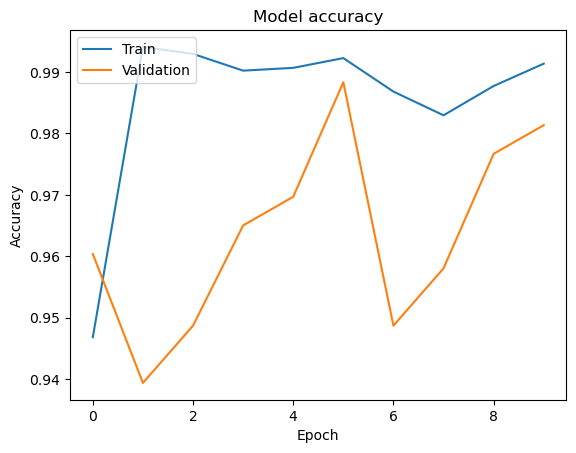

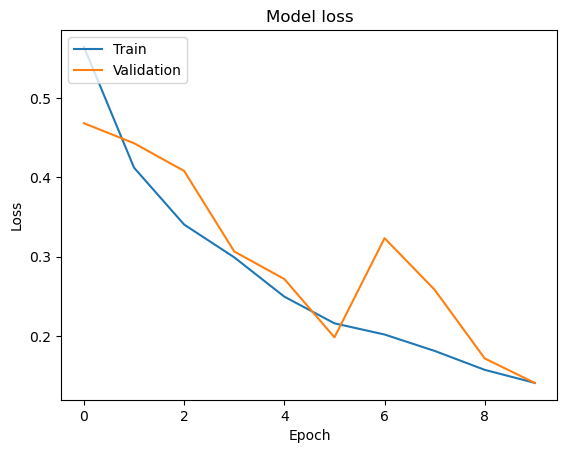

In [140]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(tuned_history.history['accuracy'])
plt.plot(tuned_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(tuned_history.history['loss'])
plt.plot(tuned_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Confusion Matrix

conda install scikit-learn
conda install seaborn

9/9 [==============================] - 1s 85ms/step


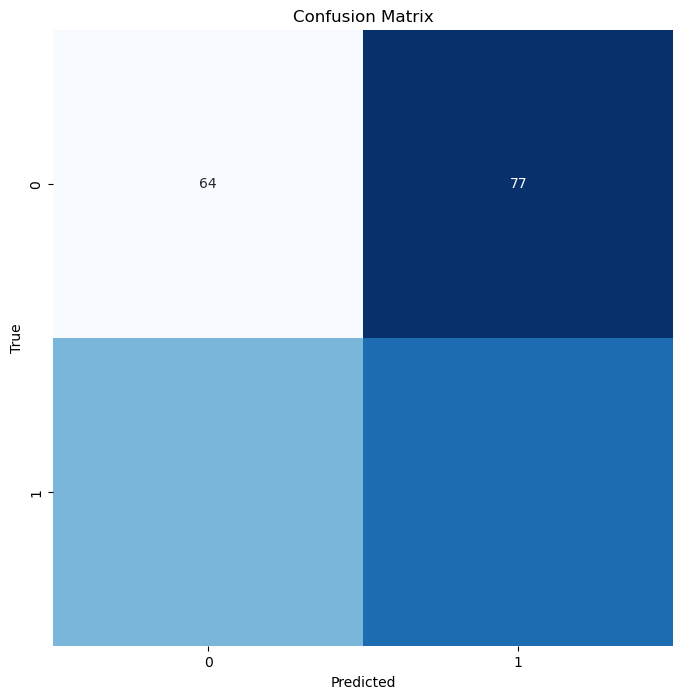

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
predictions = best_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = (predictions > 0.5).astype(int)

# # Get the classes from each generator
# limited_train_classes = limited_train_generator.classes
# augmented_bad_classes = augmented_bad_generator.classes
# # Use the classes obtained earlier
# combined_generator_classes = np.concatenate([limited_train_classes, augmented_bad_classes])

# Get true labels
true_classes = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [143]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(true_classes, predicted_classes))


              precision    recall  f1-score   support

           0       0.48      0.45      0.47       141
           1       0.49      0.51      0.50       144

    accuracy                           0.48       285
   macro avg       0.48      0.48      0.48       285
weighted avg       0.48      0.48      0.48       285



### ROC Curve and AUC


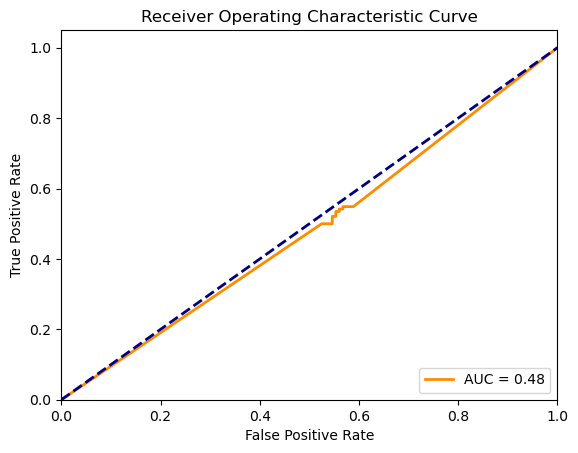

In [144]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


### Visualizing Activations

1/1 [==============================] - 0s 132ms/step
Shape of activations:  (1, 1)


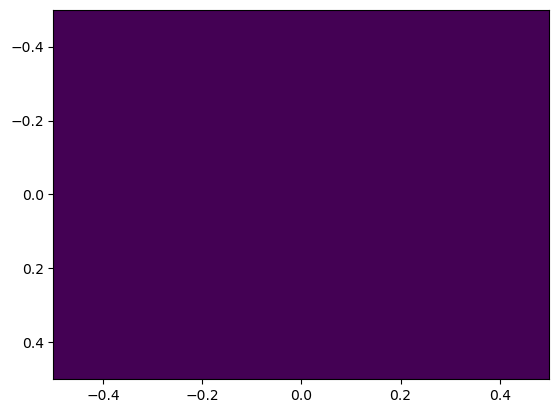

In [150]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

model = best_model  

# Specify the layer to visualize
desired_layer_index = 3 

# If the desired_layer_index is within the range of model layers
if desired_layer_index < len(model.layers):
    # Define a model that outputs the layer activations
    activation_model = Model(inputs=model.input, outputs=model.layers[desired_layer_index].output)
else:
    print("desired_layer_index is out of range. Please choose a valid layer index.")

img_path = root_dir + 'test\Bad\S1\Image0000011078.bmp'

# Load the image and preprocess it
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.  # Model was trained with inputs being normalized

# Define a model that outputs the layer activations
activation_model = Model(inputs=model.input, outputs=model.layers[desired_layer_index].output)

# Get the activations for the chosen sample
activations = activation_model.predict(img_tensor)

# Check the shape of the activations
print("Shape of activations: ", activations.shape)

# Visualize the activations
if len(activations.shape) == 4:
    # If the activations are 4-dimensional, visualize the first channel of the first sample
    plt.imshow(activations[0, :, :, 0], cmap='viridis')
elif len(activations.shape) == 2:
    # If the activations are 2-dimensional, visualize the activations of the first sample
    plt.imshow(activations[0, :].reshape(1, -1), cmap='viridis', aspect='auto')
else:
    print("Cannot visualize activations with shape ", activations.shape)
plt.show()

### Grad-CAM (Gradient-weighted Class Activation Mapping)

While working with image data, Grad-CAM (Gradient-weighted Class Activation Mapping) can help visualize which regions of the input image were important for predictions.



In [153]:
from tensorflow.keras import backend as K
import tensorflow as tf

import cv2

# Specify the layer to visualize
layer_name = 'block5_conv3' 

# Get the output of the layer
layer_output = combined_model.get_layer(layer_name).output

# Use tf.GradientTape to compute gradients
with tf.GradientTape() as tape:
    pooled_grads = tf.reduce_mean(tape.gradient(combined_model.output, layer_output), axis=(0, 1, 2))


# Access the values of the quantities we just defined: pooled_grads and the output feature map of block5_conv3
iterate = tf.function([combined_model.input], [pooled_grads, layer_output[0]])


# Values of these two quantities, as Numpy arrays, given our sample image
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

# Multiply each channel in the feature map array by "how important this channel is" with regard to the class
for i in range(conv_layer_output_value.shape[-1]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map is the heatmap of the class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

# Normalize the heatmap between 0 & 1 for visualization
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Use cv2 to superimpose the heatmap on original image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('grad_cam.jpg', superimposed_img)

AttributeError: 'KerasTensor' object has no attribute '_id'

### Plot Model

In [161]:
from keras.utils import plot_model
plot_model(best_model, to_file='best_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Ensemble Methods Using %10 of the Bad Images:

In [74]:

# limited_train_dir = '/content/drive/My Drive/student_dataset/train_limited_10'
# augmented_bad_dir = '/content/drive/My Drive/student_dataset/train_augmented_bad_10'

import numpy as np


limited_train_dir = './student_dataset/train_limited_10'
augmented_bad_dir = './student_dataset/train_augmented_bad_10'


# Data augmentation for both good and bad images in train set
limited_train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow the limited training set
limited_train_generator = limited_train_datagen.flow_from_directory(
    limited_train_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Flow the augmented bad images
augmented_bad_generator = limited_train_datagen.flow_from_directory(
    augmented_bad_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Combine the generators using the ConcatenateImageGenerator class
class ConcatenateImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, *generators):
        self.generators = generators
        self.length = sum(len(generator) for generator in generators)

    def __len__(self):
        return self.length

    # def __getitem__(self, index):
    #     return tuple(generator[index % len(generator)] for generator in self.generators)
    def __getitem__(self, index):
        # Get the inputs and labels from each generator
        batches = [generator[index % len(generator)] for generator in self.generators]
        
        # Concatenate the inputs and labels
        inputs = np.concatenate([batch[0] for batch in batches])
        labels = np.concatenate([batch[1] for batch in batches])
        
        return inputs, labels

# Create a combined generator
combined_generator = ConcatenateImageGenerator(limited_train_generator, augmented_bad_generator)


Found 1202 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## 1. Create VGG16 Model:

In [75]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create VGG16 model
vgg16_model = create_vgg16_model()


## 2. Create the Initial Model:

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_initial_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the initial model
initial_model = create_initial_model()


## 3. Create the Model with Dropout:

In [85]:
def create_model_with_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))  # Added Dropout layer

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))  # Added Dropout layer

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))  # Added Dropout layer

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model with dropout
model_with_dropout = create_model_with_dropout()

In [82]:
from keras.wrappers.scikit_learn import KerasClassifier
# Create a KerasClassifier for use in the ensemble
# Create and train the Keras model
keras_model = create_initial_model()
keras_model.fit_generator(combined_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

keras_clf = KerasClassifier(build_fn=create_initial_model, epochs=100, batch_size=10, verbose=0)
keras_clf.model = keras_model



C:\Users\Harun\AppData\Local\Temp\ipykernel_19684\854857994.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  keras_model.fit_generator(combined_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])


Epoch 1/20
69/69 [==============================] - 19s 262ms/step - loss: 0.2219 - accuracy: 0.8816 - val_loss: 0.3016 - val_accuracy: 0.9021
Epoch 2/20
69/69 [==============================] - 18s 264ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.2441 - val_accuracy: 0.9301
Epoch 3/20
69/69 [==============================] - 19s 267ms/step - loss: 0.0328 - accuracy: 0.9920 - val_loss: 0.0682 - val_accuracy: 0.9790
Epoch 4/20
69/69 [==============================] - 18s 263ms/step - loss: 0.0222 - accuracy: 0.9948 - val_loss: 0.1625 - val_accuracy: 0.9510
Epoch 5/20
69/69 [==============================] - 18s 267ms/step - loss: 0.0225 - accuracy: 0.9943 - val_loss: 0.1047 - val_accuracy: 0.9650
Epoch 6/20
69/69 [==============================] - 18s 264ms/step - loss: 0.0222 - accuracy: 0.9952 - val_loss: 0.1048 - val_accuracy: 0.9674


C:\Users\Harun\AppData\Local\Temp\ipykernel_19684\854857994.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_fn=create_initial_model, epochs=100, batch_size=10, verbose=0)


## 4. Combine Models into an Ensemble with Overfitting Avoidance:

Voting Classifier takes a list of different estimators as arguments and a voting method. The voting method can be either 'hard' or 'soft'. In hard voting, the final prediction is a majority vote among the estimators. In soft voting, the output class is the prediction based on the argmax of the sums of the predicted probabilities.


### Soft voting

In [90]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train each model individually with early stopping
vgg16_model.fit(combined_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])
initial_model.fit(combined_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])
model_with_dropout.fit(combined_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

# Make predictions on the validation set using each model
vgg16_predictions = vgg16_model.predict(validation_generator)
initial_predictions = initial_model.predict(validation_generator)
dropout_predictions = model_with_dropout.predict(validation_generator)


# Combine the models into an ensemble
ensemble_model_soft = VotingClassifier(
    estimators=[
        ('vgg16', vgg16_model),
        ('initial_model', initial_model),
        ('model_with_dropout', model_with_dropout)
    ],
    voting='soft'
)

# Combine predictions into an ensemble
ensemble_predictions_soft = np.mean([vgg16_predictions, initial_predictions, dropout_predictions], axis=0)
ensemble_predictions_soft = (ensemble_predictions_soft > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the ensemble model
ensemble_accuracy_soft = accuracy_score(validation_generator.classes, ensemble_predictions_soft)


# # Evaluate the ensemble model
# ensemble_predictions_soft = ensemble_model_soft.predict(validation_generator)
# ensemble_accuracy_soft = accuracy_score(validation_generator.classes, ensemble_predictions_soft)


print(f'Ensemble Model Accuracy: {ensemble_accuracy_soft}')


Epoch 1/20
69/69 [==============================] - 19s 269ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0519 - val_accuracy: 0.9837
Epoch 2/20
69/69 [==============================] - 19s 270ms/step - loss: 0.0273 - accuracy: 0.9914 - val_loss: 0.1694 - val_accuracy: 0.9464
Epoch 3/20
69/69 [==============================] - 19s 272ms/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.1435 - val_accuracy: 0.9510
Epoch 4/20
69/69 [==============================] - 19s 270ms/step - loss: 0.0219 - accuracy: 0.9952 - val_loss: 0.0594 - val_accuracy: 0.9790
Epoch 1/20
69/69 [==============================] - 19s 269ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.0570 - val_accuracy: 0.9883
Epoch 2/20
69/69 [==============================] - 19s 267ms/step - loss: 0.0127 - accuracy: 0.9975 - val_loss: 0.0642 - val_accuracy: 0.9837
Epoch 3/20
69/69 [==============================] - 19s 270ms/step - loss: 0.0121 - accuracy: 0.9975 - val_loss: 0.0826 - val_accuracy: 0.9837

### Hard voting

In [97]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create a KerasClassifier for use in the ensemble
# Create a new instance of each model with the trained weights
keras_clf_vgg16 = KerasClassifier(build_fn=vgg16_model, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])
keras_clf_initial = KerasClassifier(build_fn=initial_model, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])
keras_clf_dropout = KerasClassifier(build_fn=model_with_dropout, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])

# Define the classifiers for the ensemble
clf1 = keras_clf_vgg16
clf2 = keras_clf_initial
clf3 = keras_clf_dropout

# Combine the models into an ensemble
ensemble_model_hard = VotingClassifier(
    estimators=[
        ('vgg16', clf1),
        ('initial_model', clf2),
        ('keras_clf', clf3)
    ],
    voting='hard'
)

# Train the ensemble model
ensemble_model_hard.fit(combined_generator)

# Fit the ensemble model on some dummy data
# This is necessary because VotingClassifier requires a call to fit before predict,
# but the individual models have already been trained
# ensemble_model_hard.fit(np.array([[0]]), np.array([0]))


# Predict the test data
y_pred = ensemble_model_hard.predict(test_generator)

# Get the actual labels
y_true = test_generator.classes

# Print the accuracy score
print('Ensemble Model Accuracy:', accuracy_score(y_true, y_pred))



C:\Users\Harun\AppData\Local\Temp\ipykernel_19684\244576276.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf_vgg16 = KerasClassifier(build_fn=vgg16_model, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])
C:\Users\Harun\AppData\Local\Temp\ipykernel_19684\244576276.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf_initial = KerasClassifier(build_fn=initial_model, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])
C:\Users\Harun\AppData\Local\Temp\ipykernel_19684\244576276.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/mig

TypeError: fit() missing 1 required positional argument: 'y'

# SVMs Using %10 of the Bad Images:

In [117]:
import numpy as np
from tensorflow.keras.models import Model

def extract_features(model, data_generator):
    # Extract features using the specified model
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flatten_2').output)

    # Initialize lists to store features and labels
    features_list = []
    labels_list = []

    # Extract features and labels batch by batch
    for i in range(len(data_generator)):
        batch_data, batch_labels = data_generator[i]

        # Extract features for the current batch
        batch_features = feature_extractor.predict(batch_data)

        # Append the features and labels to the lists
        features_list.append(batch_features)
        labels_list.append(batch_labels)

    # Concatenate features and labels
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    return features, labels



## 1. Extract VGG16 Features:


In [118]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

combined_generator.batch_size = 32

# Extract features from VGG16 model for training and validation
train_vgg16_features = extract_features(vgg16_model, combined_generator)
validation_vgg16_features = extract_features(vgg16_model, validation_generator)


1/1 [==============================] - 0s 103ms/step


## 2. Train SVM on VGG16 Features:


In [ ]:
# Train SVM on VGG16 features
svm_model = make_pipeline(StandardScaler(), SVC())
svm_model.fit(train_vgg16_features, train_generator.classes)

# Evaluate SVM on validation set
svm_accuracy = svm_model.score(validation_vgg16_features, validation_generator.classes)
print(f'SVM Model Accuracy: {svm_accuracy}')


## 3. SVM with Overfitting Avoidance:


In [139]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Extract features from VGG16 model for training and validation
train_vgg16_features, train_labels = extract_features(vgg16_model, combined_generator)
validation_vgg16_features, validation_labels = extract_features(vgg16_model, validation_generator)


# Unpack the tuple and reshape features to 2D
train_vgg16_features_flat = train_vgg16_features[0].reshape(train_vgg16_features[0].shape[0], -1)
validation_vgg16_features_flat = validation_vgg16_features[0].reshape(validation_vgg16_features[0].shape[0], -1)

# Ensure the number of samples matches
min_samples = min(train_vgg16_features_flat.shape[0], len(train_labels), validation_vgg16_features_flat.shape[0], len(validation_labels))

# Use the minimum number of samples
train_vgg16_features_flat = train_vgg16_features_flat[:min_samples]
train_labels = train_labels[:min_samples]
validation_vgg16_features_flat = validation_vgg16_features_flat[:min_samples]
validation_labels = validation_labels[:min_samples]

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Get the classes from each generator
limited_train_classes = limited_train_generator.classes
augmented_bad_classes = augmented_bad_generator.classes
# Use the classes obtained earlier
combined_generator_classes = np.concatenate([limited_train_classes, augmented_bad_classes])

# # Assuming that train_generator and validation_generator are your data generators
# train_labels = combined_generator_classes
# validation_labels = validation_generator.classes

# Ensure the number of samples matches
if train_vgg16_features_flat.shape[0] != len(train_labels) or validation_vgg16_features_flat.shape[0] != len(validation_labels):
    raise ValueError("Number of samples in features and labels don't match.")

# Train SVM on VGG16 features with early stopping
svm_model = make_pipeline(StandardScaler(), SVC())
svm_model.fit(train_vgg16_features_flat, train_labels)

# Manually monitor validation loss during training
epochs = 20
best_val_loss = float('inf')  # Initialize with a high value

for epoch in range(epochs):  
    val_loss = svm_model.score(validation_vgg16_features_flat, validation_labels)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update best loss
    else:
        print("Early stopping!")
        break

# # Evaluate SVM on validation set
# svm_accuracy = svm_model.score(validation_vgg16_features, validation_generator.classes)
# print(f'SVM Model Accuracy: {svm_accuracy}')

# Evaluate SVM on validation set
svm_accuracy = svm_model.score(validation_vgg16_features_flat, validation_labels)
print(f'SVM Model Accuracy: {svm_accuracy}')

1/1 [==============================] - 0s 97ms/step
Epoch 1, Validation Loss: 0.4988344988344988
Epoch 2, Validation Loss: 0.4988344988344988
Early stopping!
SVM Model Accuracy: 0.4988344988344988


Epoch 1, Validation Loss: 0.4988344988344988

Epoch 2, Validation Loss: 0.4988344988344988

Early stopping!

SVM Model Accuracy: 0.4988344988344988

time:28.1s